# 🧠 03 - Treinamento do Modelo
Este notebook realiza a separação das variáveis, balanceamento da base com SMOTE e treinamento do modelo de classificação para prever inadimplência.

### Analise Exploratória - Variáveis Numéricas

<br>
Nesta analise temos diversos objetivos:<br>
1 - Conhecer as variáveis.<br>
2 - Realizar uma analise estatistica nas variáveis para futuros tratamentos. Iremos avaliar média, mediana, moda, desvio padrão
correlações, outliers, distribuição dos dados, etc. 

In [1]:
#Importação de pacotes
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import joblib # Utilizado para salvar o modelo preditivo
from sklearn.preprocessing import LabelEncoder #Utilizada para fazer o OneHotEncoding
from sklearn.metrics import mean_squared_error,precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix
from imblearn import under_sampling, over_sampling #Utilizada para fazer o balanceamento de dados
from imblearn.over_sampling import SMOTE #Utilizada para fazer o balanceamento de dados
from sklearn.preprocessing import MinMaxScaler #Utilizada para fazer a padronização dos dados
from sklearn.metrics import r2_score # Utilizado para medir a acuracia do modelo preditivo
import pyodbc as sql # Substituição de pymssql para conexão SQL

warnings.filterwarnings("ignore") 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
#pd.options.display.float_format = '{:.2f}'.format

In [2]:
# exportando os dados para um arquivo excel
df_dados = pd.read_excel('C:/Users/leojo/Desktop/PROJETO_INADIMPLENCIA_COMPLETO/data\processed/df_dados_pt_2.xlsx')

In [3]:
df_dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10410 entries, 0 to 10409
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   TAXA_AO_ANO                     10410 non-null  float64
 1   CIDADE_CLIENTE                  10410 non-null  object 
 2   ESTADO_CLIENTE                  10410 non-null  object 
 3   RENDA_MENSAL_CLIENTE            10410 non-null  int64  
 4   QT_PC_ATRASO                    10410 non-null  int64  
 5   QT_DIAS_PRIM_PC_ATRASO          10410 non-null  int64  
 6   QT_TOTAL_PC_PAGAS               10410 non-null  int64  
 7   VL_TOTAL_PC_PAGAS               10410 non-null  float64
 8   QT_PC_PAGA_EM_DIA               10410 non-null  int64  
 9   QT_DIAS_MIN_ATRASO              10410 non-null  int64  
 10  QT_DIAS_MAX_ATRASO              10410 non-null  int64  
 11  QT_DIAS_MEDIA_ATRASO            10410 non-null  int64  
 12  VALOR_PARCELA                   

In [4]:
#carregar variaveis para plot
variaveis_numericas = []
for i in df_dados.columns[0:17].tolist():
        if df_dados.dtypes[i] == 'int64' or df_dados.dtypes[i] == 'float64':                        
            variaveis_numericas.append(i)    

In [5]:
#Visualizando as variáveis numéricas
variaveis_numericas

['TAXA_AO_ANO',
 'RENDA_MENSAL_CLIENTE',
 'QT_PC_ATRASO',
 'QT_DIAS_PRIM_PC_ATRASO',
 'QT_TOTAL_PC_PAGAS',
 'VL_TOTAL_PC_PAGAS',
 'QT_PC_PAGA_EM_DIA',
 'QT_DIAS_MIN_ATRASO',
 'QT_DIAS_MAX_ATRASO',
 'QT_DIAS_MEDIA_ATRASO',
 'VALOR_PARCELA',
 'IDADE_DATA_ASSINATURA_CONTRATO']

In [6]:
#Quantidade de variaveis
len(variaveis_numericas)

12

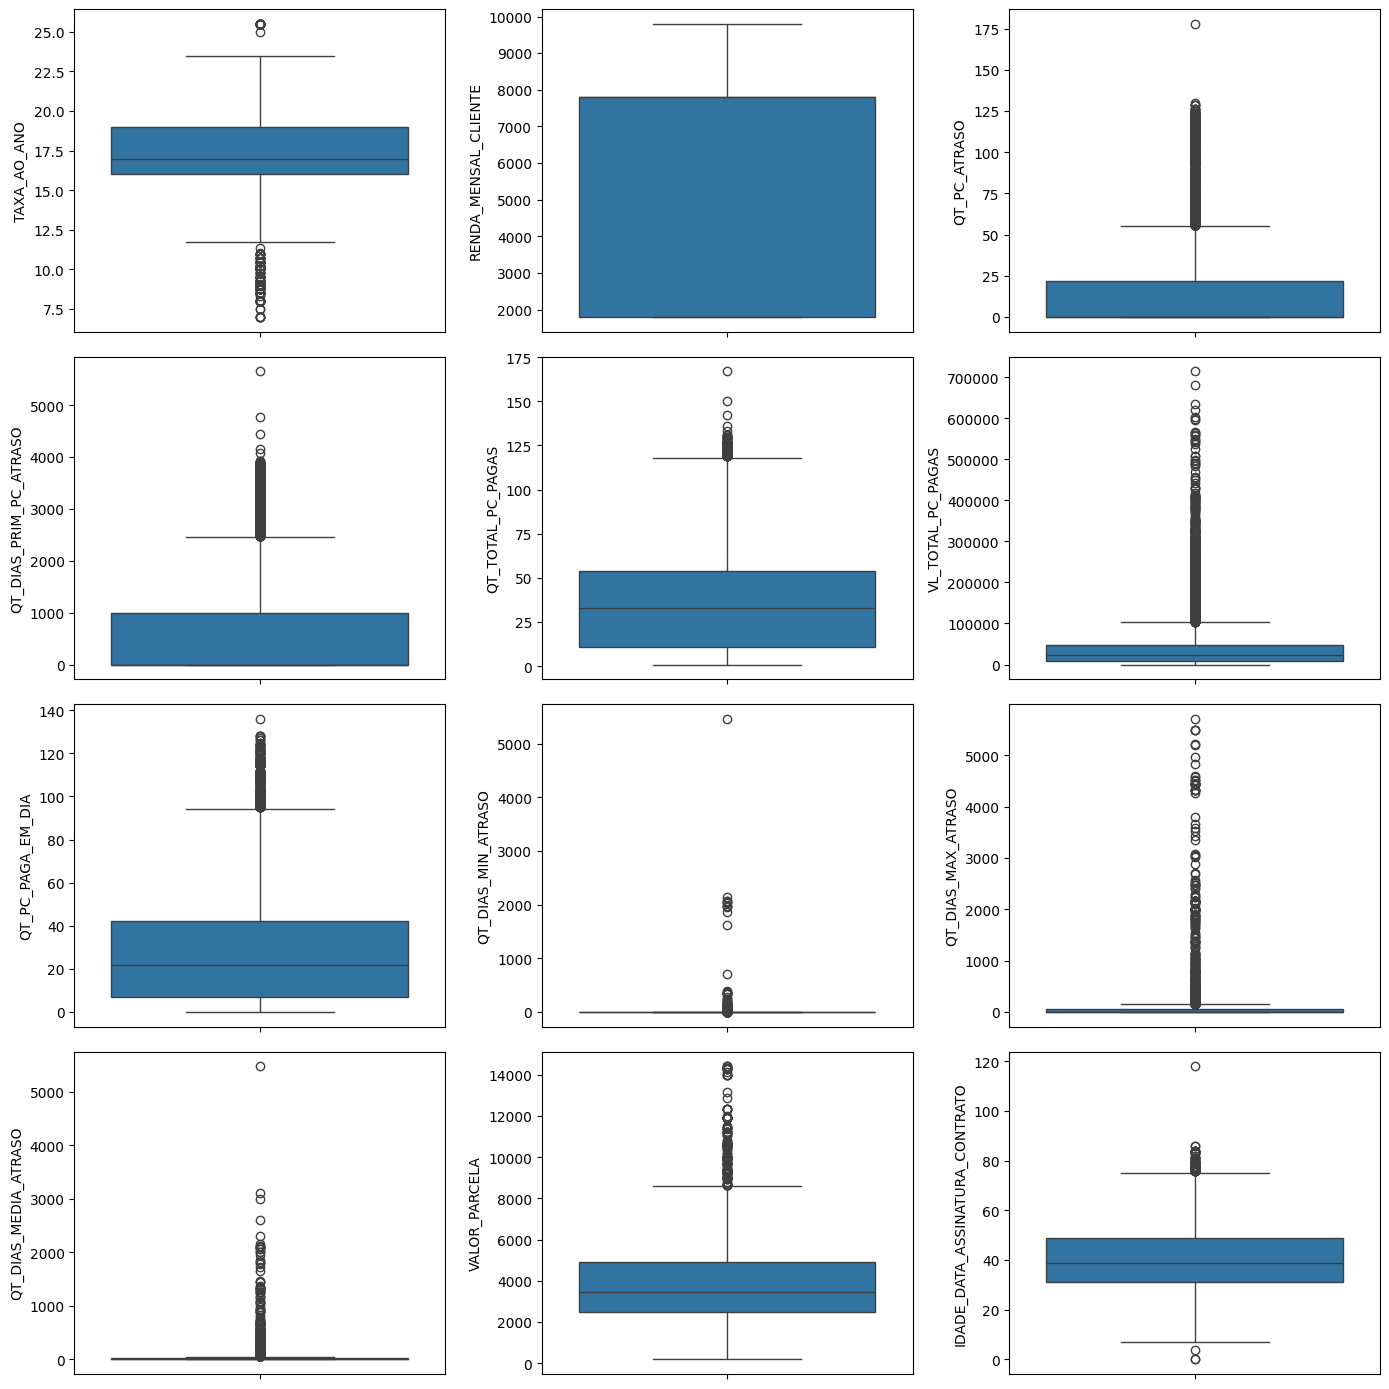

In [7]:
#Podemos observar nos boxplots abaixo que as variáveis númericas apresentam uma grande quantidade de "possíveis" outliers
#Precisamos avaliar cada uma dessas variaveis dentro do contexto dos dados para saber se realmente iremos trata-las como outlier

plt.rcParams["figure.figsize"] = [14.00, 14.00]
plt.rcParams["figure.autolayout"] = True
f, axes = plt.subplots(4, 3) #4 linhas e 3 colunas

linha = 0
coluna = 0
for i in variaveis_numericas:
    sns.boxplot(data = df_dados, y=i, ax=axes[linha][coluna])
    coluna += 1
    if coluna == 3:
        linha += 1
        coluna = 0            

plt.show()

In [8]:
# carregar variaveis categoricas para OneHotEncoding
# Colocamos o SLICE até 16 porque NÃO precisamos fazer OneHotEncoding para variavel TARGET
variaveis_categoricas = []
for i in df_dados.columns[0:16].tolist():
        if df_dados.dtypes[i] == 'object' or df_dados.dtypes[i] == 'category':                        
            variaveis_categoricas.append(i)    

In [9]:
# Visualizando as variaveis categoricas
variaveis_categoricas

['CIDADE_CLIENTE',
 'ESTADO_CLIENTE',
 'FAIXA_VALOR_FINANCIADO',
 'FAIXA_PRAZO_FINANCIAMENTO']

In [10]:
# Cria o encoder e aplica OneHotEncoder
lb = LabelEncoder()

for var in variaveis_categoricas:
    df_dados[var] = lb.fit_transform(df_dados[var])

In [11]:
df_dados.head()

,TAXA_AO_ANO,CIDADE_CLIENTE,ESTADO_CLIENTE,RENDA_MENSAL_CLIENTE,QT_PC_ATRASO,QT_DIAS_PRIM_PC_ATRASO,QT_TOTAL_PC_PAGAS,VL_TOTAL_PC_PAGAS,QT_PC_PAGA_EM_DIA,QT_DIAS_MIN_ATRASO,QT_DIAS_MAX_ATRASO,QT_DIAS_MEDIA_ATRASO,VALOR_PARCELA,IDADE_DATA_ASSINATURA_CONTRATO,FAIXA_VALOR_FINANCIADO,FAIXA_PRAZO_FINANCIAMENTO,INADIMPLENTE_COBRANCA
0,15.0,152,5,4800,0,0,97,120078.00,72,3,506,152,471.29,70,5,0,SIM
1,15.0,453,25,6800,0,0,103,156759.47,42,1,349,93,1858.69,28,2,1,SIM
2,18.0,453,25,6800,0,0,98,277125.05,83,1,151,39,3123.57,60,4,1,SIM
3,15.0,453,25,6800,0,0,87,351395.19,66,1,3797,206,2873.58,41,3,1,SIM
4,17.0,453,25,6800,0,0,71,344249.83,57,1,36,10,4224.03,63,4,1,SIM


In [12]:
# Visualizando os tipos das variaveis
df_dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10410 entries, 0 to 10409
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   TAXA_AO_ANO                     10410 non-null  float64
 1   CIDADE_CLIENTE                  10410 non-null  int64  
 2   ESTADO_CLIENTE                  10410 non-null  int64  
 3   RENDA_MENSAL_CLIENTE            10410 non-null  int64  
 4   QT_PC_ATRASO                    10410 non-null  int64  
 5   QT_DIAS_PRIM_PC_ATRASO          10410 non-null  int64  
 6   QT_TOTAL_PC_PAGAS               10410 non-null  int64  
 7   VL_TOTAL_PC_PAGAS               10410 non-null  float64
 8   QT_PC_PAGA_EM_DIA               10410 non-null  int64  
 9   QT_DIAS_MIN_ATRASO              10410 non-null  int64  
 10  QT_DIAS_MAX_ATRASO              10410 non-null  int64  
 11  QT_DIAS_MEDIA_ATRASO            10410 non-null  int64  
 12  VALOR_PARCELA                   

In [13]:
# Visualiznado a quantidade da variavel target para balanceamento
variavel_target = df_dados.INADIMPLENTE_COBRANCA.value_counts()
variavel_target

INADIMPLENTE_COBRANCA
SIM    8035
NAO    2375
Name: count, dtype: int64

In [14]:
#Separar variaveis preditoras e target
PREDITORAS = df_dados.iloc[:, 0:15]  
TARGET = df_dados.iloc[:, 16] 

In [15]:
# Visualizando as variaveis preditoras
PREDITORAS.head()

,TAXA_AO_ANO,CIDADE_CLIENTE,ESTADO_CLIENTE,RENDA_MENSAL_CLIENTE,QT_PC_ATRASO,QT_DIAS_PRIM_PC_ATRASO,QT_TOTAL_PC_PAGAS,VL_TOTAL_PC_PAGAS,QT_PC_PAGA_EM_DIA,QT_DIAS_MIN_ATRASO,QT_DIAS_MAX_ATRASO,QT_DIAS_MEDIA_ATRASO,VALOR_PARCELA,IDADE_DATA_ASSINATURA_CONTRATO,FAIXA_VALOR_FINANCIADO
0,15.0,152,5,4800,0,0,97,120078.00,72,3,506,152,471.29,70,5
1,15.0,453,25,6800,0,0,103,156759.47,42,1,349,93,1858.69,28,2
2,18.0,453,25,6800,0,0,98,277125.05,83,1,151,39,3123.57,60,4
3,15.0,453,25,6800,0,0,87,351395.19,66,1,3797,206,2873.58,41,3
4,17.0,453,25,6800,0,0,71,344249.83,57,1,36,10,4224.03,63,4


In [16]:
# Visualizando a variavel target
TARGET.head()

0    SIM
1    SIM
2    SIM
3    SIM
4    SIM
Name: INADIMPLENTE_COBRANCA, dtype: object

In [17]:
# Seed para reproduzir o mesmo resultado
seed = 100

# Cria o balanceador SMOTE
balanceador = SMOTE(random_state = seed)

# Aplica o balanceador
PREDITORAS_RES, TARGET_RES = balanceador.fit_resample(PREDITORAS, TARGET)

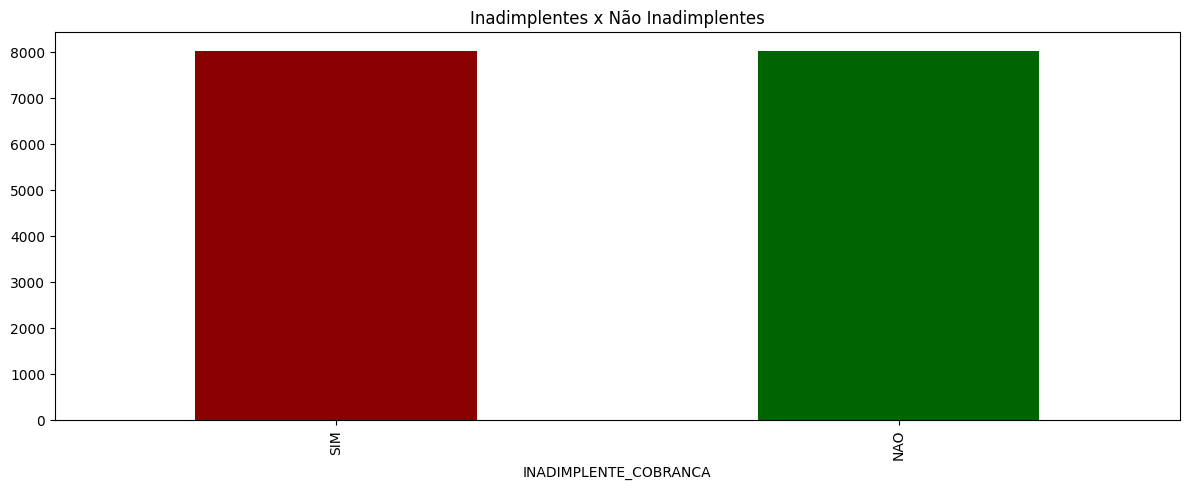

In [18]:
# Visualizando o balanceamento da variável TARGET
plt.rcParams["figure.figsize"] = [12.00, 5.00]
plt.rcParams["figure.autolayout"] = True
TARGET_RES.value_counts().plot(kind='bar', title='Inadimplentes x Não Inadimplentes',color = ['#8B0000', '#006400']);

In [19]:
# Quantidade de registros antes do balanceamento
PREDITORAS.shape

(10410, 15)

In [20]:
# Quantidade de registros antes do balanceamento
TARGET.shape

(10410,)

In [21]:
# Quantidade de registros após do balanceamento
PREDITORAS_RES.shape

(16070, 15)

# 📈 04 - Avaliação do Modelo
Este notebook avalia a performance do modelo de previsão de inadimplência usando métricas e importância das variáveis.

In [22]:
# Quantidade de registros após do balanceamento
TARGET_RES.shape

(16070,)

In [23]:
# Divisão em Dados de Treino e Teste.
X_treino, X_teste, Y_treino, Y_teste = train_test_split(PREDITORAS_RES, TARGET_RES, test_size = 0.3, random_state = 42)

In [24]:
# Normalizando as Variáveis - Pré Processamento dos Dados
Normalizador = MinMaxScaler()
X_treino_normalizados = Normalizador.fit_transform(X_treino)
X_teste_normalizados = Normalizador.transform(X_teste)

In [25]:
# visualizando a dimensão dos dados de treino
X_treino_normalizados.shape

(11249, 15)

In [26]:
# visualizando os dados de treino normalizados
X_treino_normalizados

array([[0.45945946, 0.03816794, 0.15384615, ..., 0.50322829, 0.22033898,
        0.57142857],
       [0.66904491, 0.12977099, 0.23076923, ..., 0.40839172, 0.40677966,
        0.42857143],
       [0.59459459, 0.3110687 , 0.30769231, ..., 0.03970892, 0.25423729,
        0.        ],
       ...,
       [0.10810811, 0.3110687 , 0.30769231, ..., 0.16001324, 0.34745763,
        0.        ],
       [0.64864865, 0.86450382, 0.96153846, ..., 0.23265885, 0.44067797,
        0.14285714],
       [0.42432432, 0.10305344, 0.38461538, ..., 0.03852714, 0.3559322 ,
        0.        ]], shape=(11249, 15))

In [27]:
# Criando o classificador com Random Forest
clf = RandomForestClassifier(n_estimators  = 300)

# Construção do modelo
clf = clf.fit(X_treino_normalizados, Y_treino)

In [28]:
# Verificando a acuracia do modelo com dados de teste
scores = clf.score(X_teste_normalizados,Y_teste)
scores

0.9218004563368596

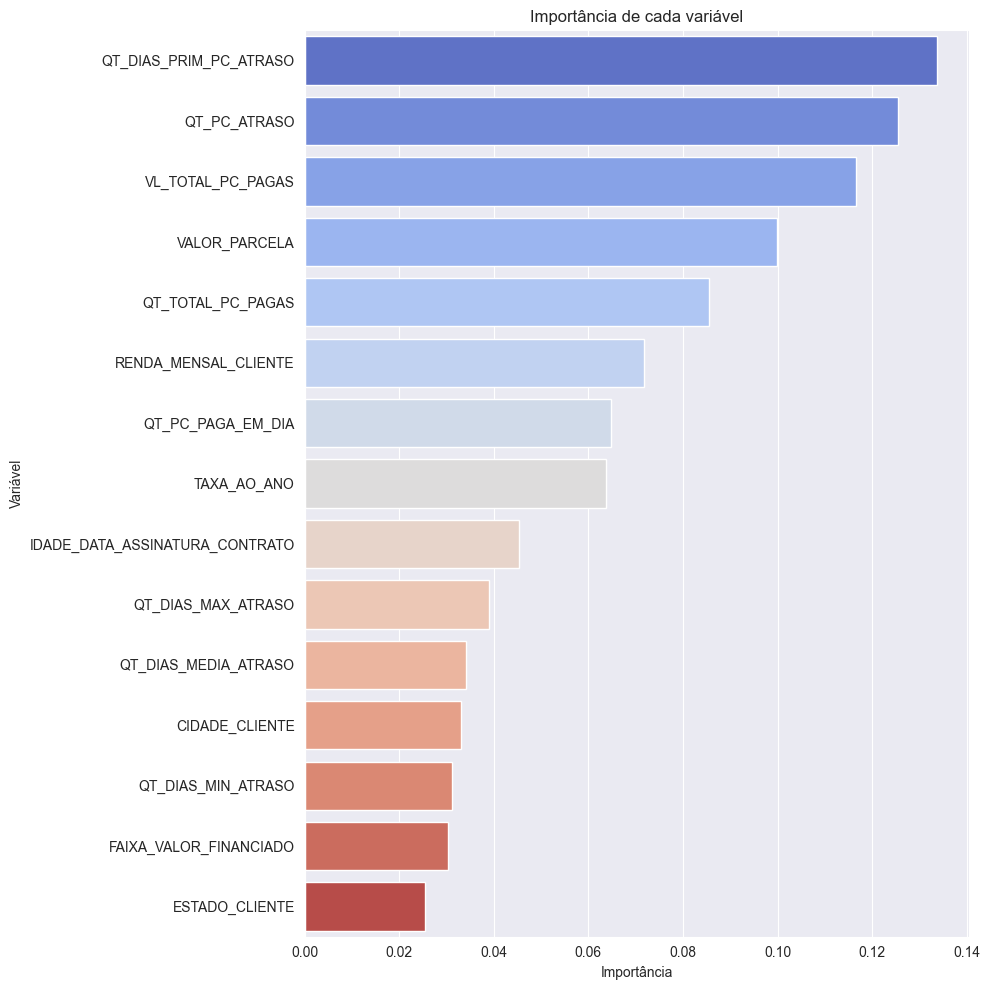

In [36]:
# Exibindo a importancia de cada variavel no modelo preditivo

# Ajustes visuais
plt.rcParams["figure.figsize"] = [10.00, 10.00]
plt.rcParams["figure.autolayout"] = True

# Importância das variáveis
importances = pd.Series(data=clf.feature_importances_, index=PREDITORAS.columns)
importances = importances.sort_values(ascending=False)

# Paleta de cores 
sns.set_style("darkgrid")
sns.barplot(
    x=importances,
    y=importances.index,
    palette="coolwarm"  # você pode testar também 'magma', 'rocket', 'coolwarm'
).set_title('Importância de cada variável')

plt.xlabel("Importância")
plt.ylabel("Variável")
plt.show()


In [37]:
importances.sort_values(ascending = False)

QT_DIAS_PRIM_PC_ATRASO            0.133723
QT_PC_ATRASO                      0.125495
VL_TOTAL_PC_PAGAS                 0.116588
VALOR_PARCELA                     0.099892
QT_TOTAL_PC_PAGAS                 0.085484
RENDA_MENSAL_CLIENTE              0.071782
QT_PC_PAGA_EM_DIA                 0.064706
TAXA_AO_ANO                       0.063652
IDADE_DATA_ASSINATURA_CONTRATO    0.045399
QT_DIAS_MAX_ATRASO                0.039000
QT_DIAS_MEDIA_ATRASO              0.034148
CIDADE_CLIENTE                    0.033073
QT_DIAS_MIN_ATRASO                0.031243
FAIXA_VALOR_FINANCIADO            0.030377
ESTADO_CLIENTE                    0.025439
dtype: float64

In [ ]:
# Salvando o modelo criado e treinado
joblib.dump(clf, 'C:/Users/leojo/Desktop/PROJETO_INADIMPLENCIA_COMPLETO/data/processed/modelo_treinado.pk')

['C:/Users/leojo/Desktop/PROJETO_INADIMPLENCIA_COMPLETO/data\\processed/modelo_treinado.pk']